In [2]:
%cd ..

/data/sunjinsheng/codebase/var_mar


In [3]:
from models.mae import mae_vit_base_patch16
model = mae_vit_base_patch16()

In [ ]:
from pathlib import Path

from PIL import Image
import torch 
import torchvision.transforms as tf
from einops import rearrange

In [4]:
path_image = 'data/RealHM/vendor_testing_2/pexels-craig-adderley-1563356_fore.jpg'

In [76]:
transfroms = tf.Compose([
    tf.Resize((224,224)),
    tf.ToTensor()
])
transfroms_gray = tf.Compose([
    tf.Grayscale(),
    tf.Resize((224, 224)),
    tf.ToTensor()
])

In [ ]:
image = Image.open(path_image).convert('RGB')

In [83]:
tensor_image = transfroms(image)
tensor_image = tensor_image.unsqueeze(0)
tensor_gray = transfroms_gray(image)
tensor_gray = tensor_gray.unsqueeze(0)
tensor_gray = tensor_gray.expand(-1, 3, -1, -1)

In [84]:
tensor_image.shape, tensor_gray.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [22]:
def tensor_2_image(x:torch.Tensor) -> Image:
    # x.shape: n c h w
    assert 4 == x.dim() 
    x = rearrange(x, 'n c h w -> c h (w n)')
    # (255*x.clip(0,1)).to(torch.uint8).cpu().numpy()
    return tf.functional.to_pil_image(x)

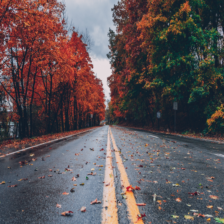

In [85]:
tensor_2_image(tensor_image)

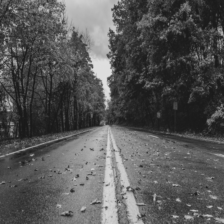

In [86]:
tensor_2_image(tensor_gray)

In [88]:
x = tensor_image.detach().clone()
x_gray = tensor_gray.detach().clone()

In [90]:
x_patched = model.patchify(x)
g_patched = model.patchify(x_gray)

In [42]:
x_patched.shape  #x: (N, L=h_*w_, patch_size**2*channel)
# patch_size : p = q = 16 
# h_ = h // p : 224 // 16 = 14
# w_ = w // q : 224 // 16 = 14 
# channel_size : c = 3
# >>
# N = 1
# L = h_ * w_ = 14 * 14 = 196  
# D = p * q * c = 16 * 16 * 3 = 768

torch.Size([1, 196, 768])

In [43]:
x_hat = model.unpatchify(x_patched)

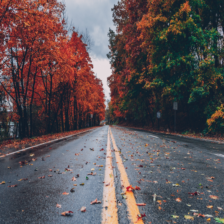

In [44]:
tensor_2_image(x_hat)

In [109]:
mask_ratio = 0.4
x_masked, mask, ids_restore = model.random_masking(x_patched, mask_ratio)

In [47]:
x_patched.shape, x_masked.shape, mask.shape, ids_restore.shape

(torch.Size([1, 196, 768]),
 torch.Size([1, 58, 768]),
 torch.Size([1, 196]),
 torch.Size([1, 196]))

In [48]:
ids_restore

tensor([[155, 116, 160, 193,  22, 100,  23,  97, 171, 161,  67, 175,  50, 150,
          38,  26, 118,  87, 195,  40, 145,  66,  80, 128,  82, 166,  25, 168,
         115,   8, 174,  49, 132,  92,   9, 189,  43, 151,  71, 102,  32, 126,
          68, 164, 138,  15,  60,  48,  24,  79,  45, 183,  77, 124,   1, 119,
         122,  53, 120, 133, 154, 172,  84, 125,  13, 113, 158,  76,  88,  63,
          62,  91,  37, 159,   2,  42, 181, 127, 140, 176, 103, 148,  69,  34,
          89,  56, 153, 137,  95, 131,  64, 117, 110,  65,  35, 165, 146, 139,
          27,  75,  93, 156, 108, 114,  33,  51,  70, 142, 177, 135, 134,  61,
          39, 149, 157,  46,  78, 136,  28, 106, 101, 143, 178,  18,   3, 162,
           5, 191,  57, 130, 107, 152,  73,   4,  86,  74, 194,  99, 141, 163,
          20,  96, 192,  17,  44,  85,  81,  31,  36,  16, 121, 104,   6,  19,
         185,  90,  41, 186, 111,  58,  29, 184,  21, 112, 144, 187,  83,  47,
         129,  59, 180,  55, 167,  54,  11,  52,  14

## random masking

In [ ]:
# def random_masking(x, mask_ratio):
"""
Perform per-sample random masking by per-sample shuffling.
Per-sample shuffling is done by argsort random noise.
x: [N, L, D], sequence
"""
N, L, D = x_patched.shape  # batch, length, dim
len_keep = int(L * (1 - mask_ratio))

In [68]:
noise = torch.rand(N, L, device=x_patched.device)  # noise in [0, 1]
noise.shape

torch.Size([1, 196])

In [69]:
# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove

In [70]:
ids_shuffle

tensor([[ 18, 158,   4, 103, 192,  90,  80, 111,  93, 139, 152, 170,  29, 177,
          81,   0,  84,  48,  60, 101, 107, 130,  89, 155, 129,  50,  24,  25,
         147,  82,  43,   1, 123, 134, 119,  51,  14, 140, 135, 159, 168,  77,
          40,  98, 175,  83, 128,  57, 195, 162,  59, 179,  12, 110,  71, 182,
         106,  16, 169, 114, 127,  33,  67, 173, 142,  55,  97,  75, 105,  74,
          35,  68,  21, 126,  10, 113, 180, 186, 188,  34,  32, 100,  69, 133,
         145, 143, 117,   2,  37, 109,  23,  44,  61,  30,  54, 141,  79,  88,
         189,  26,  52,  87, 115,  91, 148,  86,  53, 174, 118, 157, 132,  42,
         163, 160, 131, 193,  49, 122,  27, 138, 164, 181,  63,   6,  64, 183,
         178,  38,  76,  46,  45, 165,  99,  19, 149,  17,   9,  73,  41, 150,
          92, 167,   7, 120, 176, 185, 153,  47,  62,  85,  36, 108,  65,  20,
         166, 116,  95,  39,  13, 156,  28,   3,  31,  78, 187, 184,  96, 144,
         161,  22, 146,   8,  72, 190,  66, 194, 124

In [71]:
ids_restore = torch.argsort(ids_shuffle, dim=1)

In [72]:
ids_restore

tensor([[ 15,  31,  87, 161,   2, 182, 123, 142, 171, 136,  74, 178,  52, 158,
          36, 190,  57, 135,   0, 133, 153,  72, 169,  90,  26,  27,  99, 118,
         160,  12,  93, 162,  80,  61,  79,  70, 150,  88, 127, 157,  42, 138,
         111,  30,  91, 130, 129, 147,  17, 116,  25,  35, 100, 106,  94,  65,
         181,  47, 193,  50,  18,  92, 148, 122, 124, 152, 174,  62,  71,  82,
         187,  54, 172, 137,  69,  67, 128,  41, 163,  96,   6,  14,  29,  45,
          16, 149, 105, 101,  97,  22,   5, 103, 140,   8, 180, 156, 166,  66,
          43, 132,  81,  19, 186,   3, 179,  68,  56,  20, 151,  89,  53,   7,
         191,  75,  59, 102, 155,  86, 108,  34, 143, 184, 117,  32, 176, 188,
          73,  60,  46,  24,  21, 114, 110,  83,  33,  38, 183, 192, 119,   9,
          37,  95,  64,  85, 167,  84, 170,  28, 104, 134, 139, 194,  10, 146,
         185,  23, 159, 109,   1,  39, 113, 168,  49, 112, 120, 131, 154, 141,
          40,  58,  11, 189, 195,  63, 107,  44, 144

In [ ]:
# keep the first subset
ids_keep = ids_shuffle[:, :len_keep]
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L], device=x_patched.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)

# return x_masked, mask, ids_restore

## drop masking
x_mask, mask, ids_store -> x

In [115]:
mask_token = torch.ones([768])*0.2

In [116]:
mask_tokens = mask_token.repeat(x_masked.shape[0], ids_restore.shape[1] - x_masked.shape[1], 1)
mask_tokens.shape

torch.Size([1, 79, 768])

In [117]:
x_ = torch.cat([x_masked, mask_tokens], dim=1)  # no cls token
x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_masked.shape[2]))  # unshuffle
x_ = model.unpatchify(x_)

In [118]:
x_.shape

torch.Size([1, 3, 224, 224])

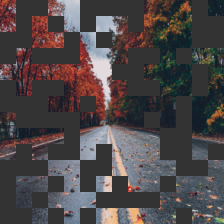

In [119]:
tensor_2_image(x_)